In [4]:
import pandas
import konlpy
import gensim

from konlpy.tag import Mecab
import numpy as np
from collections import Counter

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [5]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [12]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    """
    train_data, test_data: pandas DataFrame
        - 'document': 텍스트 스트링
        - 'label': 해당 텍스트의 레이블
    num_words: 사용할 단어 수 (사전 구성 시 가장 빈번한 num_words-1 단어를 사용하고,
               index 0은 OOV(Out-Of-Vocabulary) 용으로 사용)
    """
    # 1. 중복 데이터와 NaN(결측치) 제거 (텍스트와 레이블 모두 확인)
    train_data = train_data.drop_duplicates().dropna(subset=['document', 'label'])
    test_data = test_data.drop_duplicates().dropna(subset=['document', 'label'])
    
    # 2. 한국어 토크나이저(Mecab)를 이용하여 토큰화하고 불용어 제거
    def tokenize(text):
        # 형태소 단위의 토큰 추출 (morphs 사용)
        tokens = tokenizer.morphs(text)
        # 불용어 제거
        tokens = [token for token in tokens if token not in stopwords]
        return tokens

    # 새 컬럼 'tokens'에 토큰화 결과 저장
    train_data['tokens'] = train_data['document'].apply(tokenize)
    test_data['tokens'] = test_data['document'].apply(tokenize)
    
    # 3. 사전(word_to_index) 구성: train 데이터에 나타난 모든 토큰의 빈도수 기반
    all_tokens = [token for tokens in train_data['tokens'] for token in tokens]
    counter = Counter(all_tokens)
    # num_words-1개 단어를 선택 (인덱스 0은 OOV 용으로 예약)
    most_common = counter.most_common(num_words - 1)
    word_to_index = {word: idx + 1 for idx, (word, _) in enumerate(most_common)}
    
    # 4. 각 텍스트(토큰 리스트)를 사전 인덱스 스트링으로 변환
    def tokens_to_indices(tokens):
        # 토큰이 사전에 없으면 0 (OOV)으로 처리
        return [word_to_index.get(token, 0) for token in tokens]
    
    X_train = train_data['tokens'].apply(tokens_to_indices).tolist()
    y_train = train_data['label'].tolist()
    X_test = test_data['tokens'].apply(tokens_to_indices).tolist()
    y_test = test_data['label'].tolist()
    
    return X_train, y_train, X_test, y_test, word_to_index
    
x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)

In [13]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [14]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [15]:
import numpy as np
import tensorflow as tf

# ============================================================================
# 1. 리뷰 데이터 및 문장 길이 확인
# ============================================================================
# 예시: x_train은 단어 인덱스 리스트의 리스트, y_train은 해당 라벨 리스트
print("첫번째 리뷰 (인덱스 리스트):", x_train[0])
print("첫번째 리뷰 라벨:", y_train[0])
print("1번째 리뷰 문장 길이:", len(x_train[0]))
print("2번째 리뷰 문장 길이:", len(x_train[1]))

# 사전 매핑 확인
print("\n예시 - index_to_word[1]:", index_to_word.get(1))  # index 1에 해당하는 단어 출력

# 첫번째 리뷰 디코딩 결과 출력
print("\n디코딩된 첫번째 리뷰:")
print(get_decoded_sentence(x_train[0], index_to_word))

# ============================================================================
# 2. 문장 길이 분포 분석 및 적절한 최대 문장 길이(maxlen) 지정
# ============================================================================
# 학습과 테스트 데이터를 모두 합쳐 문장 길이 분포를 분석합니다.
total_data = list(x_train) + list(x_test)
num_tokens = np.array([len(tokens) for tokens in total_data])

print("\n문장 길이 통계:")
print("문장 길이 평균    :", np.mean(num_tokens))
print("문장 길이 최대    :", np.max(num_tokens))
print("문장 길이 표준편차:", np.std(num_tokens))

# 예시: 최대 길이를 (평균 + 2×표준편차)로 설정
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print("\npad_sequences의 maxlen:", maxlen)

percentage = np.sum(num_tokens < max_tokens) / len(num_tokens) * 100
print(f"전체 문장의 {percentage:.2f}%가 maxlen ({maxlen}) 이내에 포함됩니다.")

# ============================================================================
# 4. keras.preprocessing.sequence.pad_sequences 를 활용한 패딩 추가
# ============================================================================
# 패딩에 사용할 값은 보통 '<PAD>' 토큰에 해당하는 인덱스입니다.
# 만약 load_data()에서 '<PAD>' 토큰을 지정하지 않았다면, 기본값 0을 사용합니다.
pad_value = word_to_index.get("<PAD>", 0)

# 여기서는 post-padding(문장 뒤쪽에 패딩 추가)을 예시로 합니다.
x_train_padded = tf.keras.preprocessing.sequence.pad_sequences(
    x_train,
    value=pad_value,
    padding='post',  # 'pre'를 선택하면 앞쪽에 패딩 추가
    maxlen=maxlen
)

x_test_padded = tf.keras.preprocessing.sequence.pad_sequences(
    x_test,
    value=pad_value,
    padding='post',
    maxlen=maxlen
)

print("\n패딩 적용 후:")
print("Padded x_train shape:", x_train_padded.shape)


첫번째 리뷰 (인덱스 리스트): [29, 71, 918, 1, 1, 36, 227, 17, 30, 749]
첫번째 리뷰 라벨: 0
1번째 리뷰 문장 길이: 10
2번째 리뷰 문장 길이: 17

예시 - index_to_word[1]: .

디코딩된 첫번째 리뷰:
더 빙 . . 진짜 짜증 나 네요 목소리

문장 길이 통계:
문장 길이 평균    : 15.65940637625505
문장 길이 최대    : 116
문장 길이 표준편차: 12.859527414389605

pad_sequences의 maxlen: 41
전체 문장의 93.58%가 maxlen (41) 이내에 포함됩니다.

패딩 적용 후:
Padded x_train shape: (149995, 41)


In [16]:
import numpy as np
import tensorflow as tf

# --------------------------------------------------------------------
# 1. Validation set 구성
# --------------------------------------------------------------------
# 예시: 전체 x_train, y_train 중 처음 10000건을 validation set으로 분리
x_val = x_train[:10000]
y_val = y_train[:10000]

# validation set을 제외한 나머지 데이터
partial_x_train = x_train[10000:]
partial_y_train = y_train[10000:]

print("partial_x_train shape:", np.shape(partial_x_train))
print("partial_y_train shape:", np.shape(partial_y_train))

# --------------------------------------------------------------------
# 2. 모델 구성
# --------------------------------------------------------------------
# 공통 하이퍼파라미터
vocab_size = 10000       # 어휘 사전 크기 (예: 10,000 단어)
word_vector_dim = 16     # 임베딩(워드 벡터) 차원
# maxlen: pad_sequences()를 통해 지정한 최대 문장 길이 (예시: 이미 정의되어 있다고 가정)

# --------------------------
# 모델 1: LSTM 기반 모델
# --------------------------
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_length=maxlen),
    tf.keras.layers.LSTM(8),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # 이진 분류: sigmoid 사용
])
print("\n=== LSTM 기반 모델 ===")
model_lstm.summary()

# --------------------------
# 모델 2: 1D CNN 모델
# --------------------------
model_cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_length=maxlen),
    # 1D convolution: 필터 수 32, 커널 사이즈 7
    tf.keras.layers.Conv1D(filters=32, kernel_size=7, activation='relu'),
    # 전체 시퀀스에 대해 최대값을 취함
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
print("\n=== 1D CNN 모델 ===")
model_cnn.summary()

# --------------------------
# 모델 3: Bidirectional LSTM 모델
# --------------------------
model_bi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_length=maxlen),
    # 양방향 LSTM: 양쪽 방향의 정보를 모두 고려
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
print("\n=== Bidirectional LSTM 모델 ===")
model_bi_lstm.summary()

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


partial_x_train shape: (139995,)
partial_y_train shape: (139995,)

=== LSTM 기반 모델 ===
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 41, 16)            160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________

=== 1D CNN 모델 ===
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              

In [20]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# -----------------------------------------------------------------------------
# 1. 학습 데이터와 검증 데이터에 대해 패딩 적용 및 라벨 데이터 NumPy 배열 변환
# -----------------------------------------------------------------------------
# pad_sequences를 통해 모든 입력 시퀀스의 길이를 maxlen으로 맞춥니다.
# pad_value는 '<PAD>' 토큰에 해당하는 인덱스 (정의되어 있지 않다면 기본값 0 사용)
pad_value = word_to_index.get("<PAD>", 0)

partial_x_train_padded = pad_sequences(partial_x_train,
                                       value=pad_value,
                                       padding='post',   # 또는 'pre'
                                       maxlen=maxlen)
x_val_padded = pad_sequences(x_val,
                             value=pad_value,
                             padding='post',    # 또는 'pre'
                             maxlen=maxlen)

# 라벨 데이터를 리스트에서 NumPy 배열로 변환합니다.
partial_y_train = np.array(partial_y_train)
y_val = np.array(y_val)

# -----------------------------------------------------------------------------
# 2. 모델 학습 시작
# -----------------------------------------------------------------------------

# ---------------------------
# 모델 1: LSTM 기반 모델
# ---------------------------
print("=== LSTM 기반 모델 학습 시작 ===")
model_lstm.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

history_lstm = model_lstm.fit(partial_x_train_padded, partial_y_train,
                              epochs=10,
                              batch_size=512,
                              validation_data=(x_val_padded, y_val))
print("\nLSTM 모델 학습 완료.\n")


# ---------------------------
# 모델 2: 1D CNN 모델
# ---------------------------
print("=== 1D CNN 모델 학습 시작 ===")
model_cnn.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

history_cnn = model_cnn.fit(partial_x_train_padded, partial_y_train,
                            epochs=10,
                            batch_size=512,
                            validation_data=(x_val_padded, y_val))
print("\n1D CNN 모델 학습 완료.\n")


# ---------------------------
# 모델 3: Bidirectional LSTM 모델
# ---------------------------
print("=== Bidirectional LSTM 모델 학습 시작 ===")
model_bi_lstm.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

history_bi_lstm = model_bi_lstm.fit(partial_x_train_padded, partial_y_train,
                                    epochs=10,
                                    batch_size=512,
                                    validation_data=(x_val_padded, y_val))
print("\nBidirectional LSTM 모델 학습 완료.\n")



=== LSTM 기반 모델 학습 시작 ===
Epoch 1/10
274/274 [==============================] - 3s 6ms/step - loss: 0.2376 - accuracy: 0.8910 - val_loss: 0.4021 - val_accuracy: 0.8456
Epoch 2/10
274/274 [==============================] - 1s 5ms/step - loss: 0.2305 - accuracy: 0.8937 - val_loss: 0.4269 - val_accuracy: 0.8430
Epoch 3/10
274/274 [==============================] - 1s 5ms/step - loss: 0.2257 - accuracy: 0.8960 - val_loss: 0.4291 - val_accuracy: 0.8452
Epoch 4/10
274/274 [==============================] - 1s 5ms/step - loss: 0.2209 - accuracy: 0.8974 - val_loss: 0.4579 - val_accuracy: 0.8485
Epoch 5/10
274/274 [==============================] - 1s 5ms/step - loss: 0.2174 - accuracy: 0.8982 - val_loss: 0.4401 - val_accuracy: 0.8467
Epoch 6/10
274/274 [==============================] - 1s 5ms/step - loss: 0.2136 - accuracy: 0.8996 - val_loss: 0.4664 - val_accuracy: 0.8407
Epoch 7/10
274/274 [==============================] - 1s 5ms/step - loss: 0.2096 - accuracy: 0.9020 - val_loss: 0.4648 - va

/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 47784 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 45944 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 48708 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44368 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 47784 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 45944 missing from current font.
  font.set_te

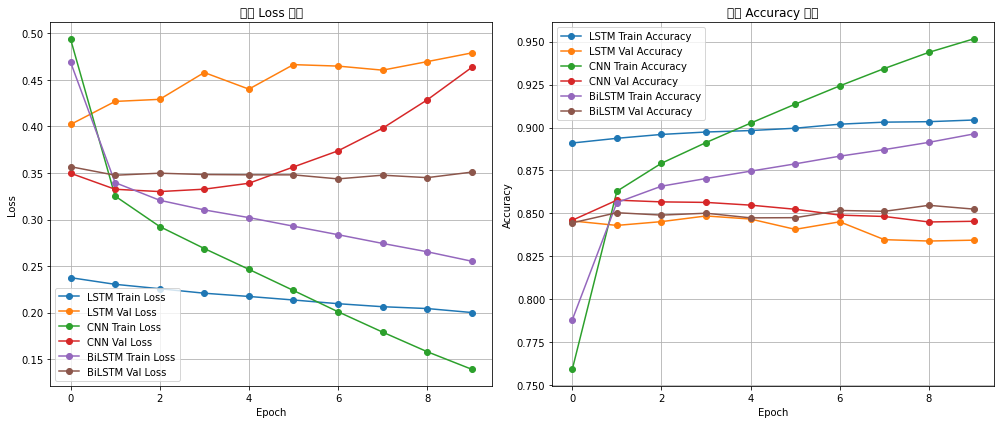

In [34]:
import matplotlib.pyplot as plt

# ---------------------------
# Loss 그래프 시각화
# ---------------------------
plt.figure(figsize=(14, 6))

# LSTM 모델 Loss
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], 'o-', label='LSTM Train Loss')
plt.plot(history_lstm.history['val_loss'], 'o-', label='LSTM Val Loss')

# 1D CNN 모델 Loss
plt.plot(history_cnn.history['loss'], 'o-', label='CNN Train Loss')
plt.plot(history_cnn.history['val_loss'], 'o-', label='CNN Val Loss')

# Bidirectional LSTM 모델 Loss
plt.plot(history_bi_lstm.history['loss'], 'o-', label='BiLSTM Train Loss')
plt.plot(history_bi_lstm.history['val_loss'], 'o-', label='BiLSTM Val Loss')

plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# ---------------------------
# Accuracy 그래프 시각화
# ---------------------------
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['accuracy'], 'o-', label='LSTM Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], 'o-', label='LSTM Val Accuracy')

plt.plot(history_cnn.history['accuracy'], 'o-', label='CNN Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], 'o-', label='CNN Val Accuracy')

plt.plot(history_bi_lstm.history['accuracy'], 'o-', label='BiLSTM Train Accuracy')
plt.plot(history_bi_lstm.history['val_accuracy'], 'o-', label='BiLSTM Val Accuracy')

plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

# =============================================================================
# 1. 임베딩 행렬 추출
# =============================================================================
# model_lstm의 첫 번째 레이어가 Embedding 레이어라고 가정합니다.
embedding_layer = model_lstm.layers[0]
# 임베딩 행렬: shape = (vocab_size, word_vector_dim)
embedding_weights = embedding_layer.get_weights()[0]
print("임베딩 행렬의 shape:", embedding_weights.shape)

# =============================================================================
# 2. 코사인 유사도를 활용한 유사 단어 탐색
# =============================================================================
def find_similar_words(target_word, top_k=5):
    """
    target_word와 유사한 단어를 코사인 유사도를 이용해 찾습니다.
    :param target_word: 분석할 단어 (str)
    :param top_k: 상위 몇 개 단어를 반환할지
    """
    # target_word가 단어 사전에 존재하는지 확인합니다.
    if target_word not in word_to_index:
        print(f"단어 '{target_word}'가 단어 사전에 없습니다.")
        return

    target_idx = word_to_index[target_word]
    target_vector = embedding_weights[target_idx].reshape(1, -1)
    
    # 전체 임베딩 행렬과 target_vector 간의 코사인 유사도를 계산합니다.
    similarities = cosine_similarity(embedding_weights, target_vector).flatten()
    
    # 자기 자신은 제외하고 유사도가 높은 단어 상위 top_k개를 찾습니다.
    similar_indices = np.argsort(similarities)[::-1][1:top_k+1]
    
    print(f"'{target_word}'와(과) 유사한 단어:")
    for idx in similar_indices:
        similar_word = index_to_word.get(idx, "?")
        print(f"{similar_word} (유사도: {similarities[idx]:.4f})")

# 예시: '영화'와 유사한 단어 5개 출력 (사전에 '영화'가 존재해야 합니다.)
find_similar_words("사랑", top_k=5)


임베딩 행렬의 shape: (10000, 16)
'사랑'와(과) 유사한 단어:
나와라 (유사도: 0.9650)
으니깐 (유사도: 0.9433)
이래서 (유사도: 0.9322)
감사 (유사도: 0.9321)
어벤져스 (유사도: 0.9292)


### 정확도 실험: 양뱡향 LSTM 모델 구조 사용

In [32]:
import os
import numpy as np
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# =============================================================================
# 1. Word2Vec 모델 불러오기 (리눅스 홈 디렉토리의 data 폴더)
# =============================================================================
word2vec_model_path = os.path.expanduser("~/data/word2vec_ko.model")

if not os.path.exists(word2vec_model_path):
    raise FileNotFoundError(f"파일을 찾을 수 없습니다: {word2vec_model_path}")
else:
    print(f"파일을 찾았습니다: {word2vec_model_path}")

word2vec_model = Word2VecKeyedVectors.load(word2vec_model_path)
word_vectors = word2vec_model.wv

# =============================================================================
# 2. pretrained 임베딩 행렬 구성
# =============================================================================
embedding_dim = word_vectors.vector_size
print("Word2Vec embedding dimension:", embedding_dim)

vocab_size = 10000

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, idx in word_to_index.items():
    if idx >= vocab_size:
        continue  # vocab_size 제한 내 단어만 사용
    if word == "<PAD>":
        embedding_matrix[idx] = np.zeros(embedding_dim)
    elif word in word_vectors:
        embedding_matrix[idx] = word_vectors[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

# =============================================================================
# 3. 데이터 준비: pad_sequences와 라벨 배열 변환
# =============================================================================
# (partial_x_train, x_val, partial_y_train, y_val, maxlen, word_to_index 등은 이미 정의되었다고 가정)
pad_value = word_to_index.get("<PAD>", 0)
partial_x_train_padded = pad_sequences(partial_x_train,
                                       maxlen=maxlen,
                                       padding='post',
                                       value=pad_value)
x_val_padded = pad_sequences(x_val,
                             maxlen=maxlen,
                             padding='post',
                             value=pad_value)

partial_y_train = np.array(partial_y_train)
y_val = np.array(y_val)

# =============================================================================
# 4. 개선된 모델 구성 (GPU 가속을 위해 LSTM 내부 dropout 제거)
# =============================================================================
model_improved = Sequential()

# pretrained Word2Vec 임베딩 (초기에는 trainable=False로 고정)
model_improved.add(Embedding(input_dim=vocab_size,
                             output_dim=embedding_dim,
                             weights=[embedding_matrix],
                             input_length=maxlen,
                             trainable=False))
model_improved.add(Dropout(0.2))  # 임베딩 후 Dropout 적용

# 양방향 LSTM 레이어 1 (내부 dropout 제거하여 cuDNN 사용)
model_improved.add(Bidirectional(LSTM(64, return_sequences=True)))
model_improved.add(BatchNormalization())
model_improved.add(Dropout(0.2))  # 외부 Dropout으로 정규화

# 양방향 LSTM 레이어 2 (내부 dropout 제거)
model_improved.add(Bidirectional(LSTM(32)))
model_improved.add(BatchNormalization())
model_improved.add(Dropout(0.2))

# 완전 연결(Dense) 레이어
model_improved.add(Dense(32, activation='relu'))
model_improved.add(BatchNormalization())
model_improved.add(Dropout(0.2))

# 이진 분류를 위한 출력층 (sigmoid 활성화)
model_improved.add(Dense(1, activation='sigmoid'))

model_improved.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

model_improved.summary()

# =============================================================================
# 5. 모델 학습 (EarlyStopping 및 ReduceLROnPlateau 콜백 적용)
# =============================================================================
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

history_improved = model_improved.fit(partial_x_train_padded, partial_y_train,
                                      epochs=20,
                                      batch_size=512,
                                      validation_data=(x_val_padded, y_val),
                                      callbacks=[early_stop, lr_reduction])


파일을 찾았습니다: /aiffel/data/word2vec_ko.model
Word2Vec embedding dimension: 100
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
dropout_16 (Dropout)         (None, 41, 100)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 41, 128)           84480     
_________________________________________________________________
batch_normalization_3 (Batch (None, 41, 128)           512       
_________________________________________________________________
dropout_17 (Dropout)         (None, 41, 128)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                41216     
____________________________________________

In [33]:
# 모델 평가: loss와 accuracy 반환 (여기서 accuracy는 검증 정확도)
loss, accuracy = model_improved.evaluate(x_val_padded, y_val, verbose=0)

# 검증 정확도 출력 (소수점 두 자리까지 % 표시)
print(f"검증 정확도: {accuracy * 100:.2f}%")

# 검증 정확도가 85% 이상인지 확인
if accuracy >= 0.85:
    print("검증 정확도가 85% 이상 달성되었습니다!")
else:
    print("검증 정확도가 85% 미만입니다!")


검증 정확도: 85.70%
검증 정확도가 85% 이상 달성되었습니다!


### word2vec으로 전이학습한 임베딩 차원의 성능 확인하기

In [29]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# '사랑'이라는 단어를 분석 대상으로 지정합니다.
target_word = "사랑"

# 전체 단어 리스트와 벡터를 가져옵니다.
all_words = word_vectors.index_to_key  # gensim 버전에 따라 index2word 또는 index_to_key 사용
all_vectors = np.array([word_vectors[word] for word in all_words])

# '사랑' 단어 벡터 추출
target_vector = word_vectors[target_word].reshape(1, -1)

# 전체 단어와의 코사인 유사도 계산
similarities = cosine_similarity(all_vectors, target_vector).flatten()

# 자기 자신은 제외하고 상위 5개 단어 추출
top_k = 5
sorted_indices = np.argsort(similarities)[::-1]
similar_results = []
for idx in sorted_indices:
    if all_words[idx] == target_word:
        continue  # 자기 자신은 제외
    similar_results.append((all_words[idx], similarities[idx]))
    if len(similar_results) >= top_k:
        break

print(f"\n(수동 계산) '{target_word}'와(과) 유사한 단어:")
for word, sim in similar_results:
    print(f"{word}: {sim:.4f}")


(수동 계산) '사랑'와(과) 유사한 단어:
이별: 0.7626
행복: 0.7550
슬픔: 0.7382
유혹: 0.7238
그리움: 0.7167


### 회고

1. 스스로 작성한 코드가 별로 없는 것 같다. 텐서플로우나 이번에 새로 배운 자연어 처리 관련 라이브러리와 익숙하지 않아서 생긴 문제인 것 같다.
2. 그래도 자연어 처리 과정의 전반적인 흐름을 경험해 본 것이라고 생각하고 내용을 추가적으로 더 학습해야겠다는 생각이 들었다.